# Multilable Classification on Patent Application Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL Project/patent_analysis_data.csv')
from sklearn.utils import shuffle
df = shuffle(df,random_state=101)

#**0. Setting Hirarchy of labels**

Remove Square brackets and quotes from Subclass_labels column

In [0]:
import re
cleaned_labels = [tuple(re.sub("\[|\]|\'", '', x).split(', ')) for x in df.Subclass_labels.values]

Convert the values of Subclass_labels column into tuples 

In [0]:
df_classes = []
for label_tuple in cleaned_labels:
  list_lbl = list(label_tuple)
  arr_class = []
  for indv_lbl in list_lbl:
    if indv_lbl[0] not in arr_class:
      arr_class.append(indv_lbl[0])
  df_classes.append(tuple(arr_class))
df.Subclass_labels = df_classes  

## **0.1 Data Snapshot**

In [6]:
df.head(10)

,Unnamed: 0,Subclass_labels,Abstract,Title,No
6676,6676,"(A,)",a metal detector digging tool apparatus has an...,metal detector digging tool apparatus,US08931816
6421,6421,"(E,)",force dampening arrangement for dampening forc...,auxiliary subsurface compensator,US08931563
9834,9834,"(A, B)",in a minimally invasive surgical system a hand...,method and system for hand presence detection ...,US08935003
8492,8492,"(H,)",a driver for an led lamp assembly includes a r...,dimmable led lamp,US08933642
9982,9982,"(G,)",a computer implemented process computer progra...,system and method for examining concurrent sys...,US08935144
8844,8844,"(H,)",a system for two dimensional 2 d or three dime...,switchable 2 d 3 d display system,US08934000
7247,7247,"(C,)",a zinc oxide precursor for use in deposition o...,zinc oxide precursor and method of depositing ...,US08932389
5862,5862,"(H,)",according to an aspect there is provided a dig...,information descriptor and extended informatio...,US08931006
3662,3662,"(H,)",an antenna comprising a network of arrayed rad...,choke reflector antenna,US08928548
3457,3457,"(G,)",a switchable viewing angle display method is p...,switchable viewing angle display,US08928567


In [0]:
single_label = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0}
multilabel = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0}
classes = ['A','B','C','D','E','F','G','H']
for i in df.Subclass_labels.values:
  list_lbl = list(i)
  for j in i:
    if len(list_lbl) > 1:
      multilabel[j] = multilabel[j] + 1
    single_label[j] = single_label[j] + 1

##**0.2 Dataset Visualization**

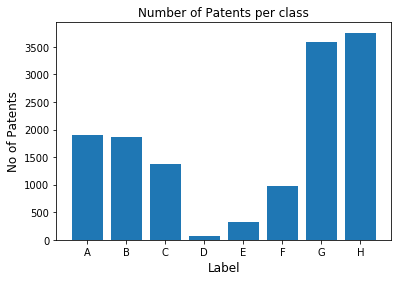

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
index = list(single_label.keys())
plt.bar(index, list(single_label.values()))
plt.xlabel('Label', fontsize=12)
plt.ylabel('No of Patents', fontsize=12)
plt.title('Number of Patents per class')
plt.show()

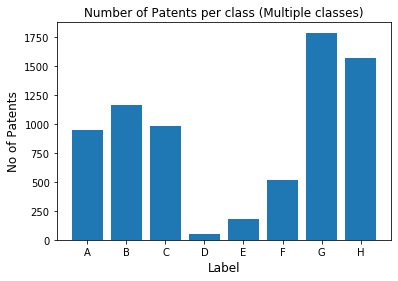

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
index = list(multilabel.keys())
plt.bar(index, list(multilabel.values()))
plt.xlabel('Label', fontsize=12)
plt.ylabel('No of Patents', fontsize=12)
plt.title('Number of Patents per class (Multiple classes)')
plt.show()

In [0]:
abstracts = df.Abstract.values
titles = df.Title.values

In [0]:
for i in range(len(abstracts)):
  abstracts[i] = titles[i] + ' : ' + abstracts[i]

In [0]:
df.Abstract = abstracts

In [13]:
df.head()

,Unnamed: 0,Subclass_labels,Abstract,Title,No
6676,6676,"(A,)",metal detector digging tool apparatus : a meta...,metal detector digging tool apparatus,US08931816
6421,6421,"(E,)",auxiliary subsurface compensator : force dampe...,auxiliary subsurface compensator,US08931563
9834,9834,"(A, B)",method and system for hand presence detection ...,method and system for hand presence detection ...,US08935003
8492,8492,"(H,)",dimmable led lamp : a driver for an led lamp a...,dimmable led lamp,US08933642
9982,9982,"(G,)",system and method for examining concurrent sys...,system and method for examining concurrent sys...,US08935144


#**1. Multilabel Classification - Baseline Model using Glove embeddings**

## **1.1 Feature Extraction**

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
texts = df.Abstract.values

In [0]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(texts)

Tokens into sequences

In [0]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

In [18]:
data.shape

(10000, 424)

Split Data into 10% test and 90% training sets

In [0]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,df.Subclass_labels,test_size=0.1,random_state=101)

### **1.1.1 Building the vocabulary**

In [0]:
word_index = tokenizer.word_index

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_t = mlb.fit_transform(y_train)
y_test_t = mlb.fit_transform(y_test)

In [22]:
mlb.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object)

### **1.1.2 Import Glove embedding file from the Drive**

In [0]:
GLOVE_FILE = '/content/drive/My Drive/Colab Notebooks/DL Project/glove.6B.100d.txt'
f = open(GLOVE_FILE,'r')

In [0]:
embeddings_index = {}
import numpy as np
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

### **1.1.3 Create an embedding matrix of weights**

In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## **1.2 Prepare keras classification model using Glove embeddings**

In [26]:
from keras.layers import Embedding,Dense,Dropout,GRU, LSTM
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(len(word_index)+1,100,weights=[embedding_matrix],trainable=False))

model.add(LSTM(units=128,dropout = 0.5,recurrent_dropout = 0.2))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8,activation="sigmoid"))
# output model skeleton
opt = Adam(lr = 0.005)
model.summary()
model.compile(optimizer= opt , loss ='binary_crossentropy',metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2206300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [0]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [28]:
X_train.shape

(9000, 424)

### **1.2.1 Add monitoring callbacks and start training**

In [29]:
early_stopping = EarlyStopping(monitor='acc', patience=6, verbose=0, mode='max')
rop = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='max')
call = [early_stopping, rop]


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


###**1.2.2 Start Training**

In [30]:
history = model.fit(X_train,y_train_t,batch_size= 256,epochs = 22,validation_split=0.08,callbacks=call)



Train on 8280 samples, validate on 720 samples
Epoch 1/22
8280/8280 [==============================] - 22s 3ms/step - loss: 0.5118 - acc: 0.7459 - val_loss: 0.3859 - val_acc: 0.8293
Epoch 2/22
8280/8280 [==============================] - 20s 2ms/step - loss: 0.3970 - acc: 0.8229 - val_loss: 0.3360 - val_acc: 0.8549
Epoch 3/22
8280/8280 [==============================] - 20s 2ms/step - loss: 0.3642 - acc: 0.8375 - val_loss: 0.3260 - val_acc: 0.8503
Epoch 4/22
8280/8280 [==============================] - 19s 2ms/step - loss: 0.3513 - acc: 0.8441 - val_loss: 0.3238 - val_acc: 0.8580
Epoch 5/22
8280/8280 [==============================] - 19s 2ms/step - loss: 0.3387 - acc: 0.8471 - val_loss: 0.3069 - val_acc: 0.8576
Epoch 6/22
8280/8280 [==============================] - 19s 2ms/step - loss: 0.3289 - acc: 0.8512 - val_loss: 0.2991 - val_acc: 0.8632
Epoch 7/22
8280/8280 [==============================] - 19s 2ms/step - loss: 0.3187 - acc: 0.8557 - val_loss: 0.2893 - val_acc: 0.8705
Epoch 

## **1.3 Evaluate the model on test data**

In [31]:
model.evaluate(X_test,y_test_t)

1000/1000 [==============================] - 4s 4ms/step


[0.25550242137908935, 0.8955]

Plot loss and accuracy graphs

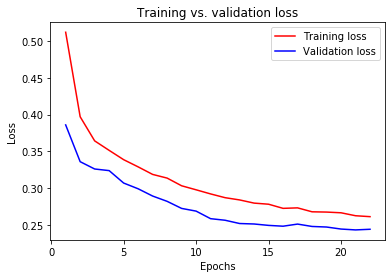

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training vs. validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

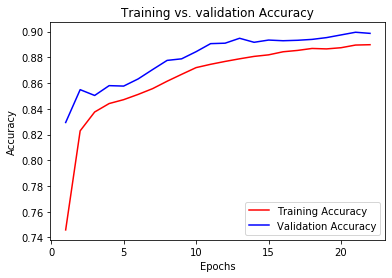

In [33]:
#Plot Accuracy
history_dict = history.history
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training Accuracy') 
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy') 
plt.title('Training vs. validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred_norm = [[1 if val >= 0.5 else 0 for val in pred]for pred in y_pred]

## **1.4 Classification Evaluation**

Since this is multilabel classification problem, we can not simply calculate the accuracy, precision, recall and F1 score. The prediction for a multilable classification problem is a set of labels and therefore the prediction could be fully correct, partially correct or fully incorrect. None of the matrices amongst precision, recall and F1 score caputures this notion in their original form. [1] 

Therefore, I use three different matrices along with precision, recall and F1 score to evaluate our multilable classifier. These are following:

1. Jaccard Score: Jaccard score is defined as the size of the intersection divided by the size of the union of two label sets. It is used to compare set of predicted labels for a sample to the corresponding set of labels.[2]
>>$J(y_i, \hat{y}_i) = \frac{|y_i \cap \hat{y}_i|}{|y_i \cup \hat{y}_i|}$

2. Subset Accuracy: In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.[2]
>>$accuracy(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$
3. Hamming Loss: If $\hat{y}_j$
 is the predicted value for the $j$-th label of a given sample, 
 is the corresponding true value, and 
 is the number of classes or labels, then the Hamming loss  between two samples is defined as:[1]
 >>$L_{Hamming}(y, \hat{y}) = \frac{1}{n_\text{labels}} \sum_{j=0}^{n_\text{labels} - 1} 1(\hat{y}_j \not= y_j)$
4. $Precision=\frac{1}{\left|S\right|} \sum_{s \in S} P(y_s, \hat{y}_s)$
5. $Recall=\frac{1}{\left|S\right|} \sum_{s \in S} R(y_s, \hat{y}_s)$
6. $F1 Score=\frac{1}{\left|S\right|} \sum_{s \in S} F_\beta(y_s, \hat{y}_s)$
Where,

>$S$ is the set of samples

>$y_s$ the subset of $y$ with sample $s$, i.e. $y_s := \left\{(s', l) \in y | s' = s\right\}$

>$\hat{y_s}$ is subset of $\hat{y}$

>$P(A, B) := \frac{\left| A \cap B \right|}{\left|A\right|}$ for some sets $A$ and $B$

>$R(A, B) := \frac{\left| A \cap B \right|}{\left|B\right|}$ (Conventions vary on handling $B = \emptyset$; this implementation uses $R(A, B):=0$, and similar for $P$.)

In multiclass and multilabel classification task, the notions of precision, recall, and F-measures can be applied to each label independently.[2]



[1]  Sorower, Mohammad S. "A literature survey on algorithms for multi-label learning." Oregon State University, Corvallis (2010).

[2] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.


In [0]:
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score, hamming_loss, multilabel_confusion_matrix, jaccard_score, classification_report

In [37]:
print("Jaccard Similarity Score : {:.4f}".format(jaccard_score(y_test_t, y_pred_norm,average='samples')))
print("Subset Accuracy : {:.4f}".format(accuracy_score(y_test_t, y_pred_norm)))
print("Hamming Loss : {:.4f}".format(hamming_loss(y_test_t,y_pred_norm)))
print("Precision: {:.4f}".format(precision_score(y_test_t, y_pred_norm, average='samples')))
print("Recall   : {:.4f}".format(recall_score(y_test_t, y_pred_norm, average='samples')))
print("F1-Score : {:.4f}".format(f1_score(y_test_t, y_pred_norm, average='samples')))

Jaccard Similarity Score : 0.5623
Subset Accuracy : 0.4420
Hamming Loss : 0.1045
Precision: 0.6605
Recall   : 0.5925
F1-Score : 0.6039


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(classification_report(y_test_t,y_pred_norm))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       176
           1       0.00      0.00      0.00       178
           2       0.77      0.68      0.72       138
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        28
           5       0.64      0.25      0.36        92
           6       0.82      0.61      0.70       383
           7       0.81      0.71      0.76       373

   micro avg       0.79      0.53      0.64      1374
   macro avg       0.47      0.37      0.41      1374
weighted avg       0.67      0.53      0.59      1374
 samples avg       0.66      0.59      0.60      1374



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**2. Fine Tuning BERT using Keras-Bert wrapper.**

In [39]:
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=f77e00e050867ca464375fa500849d667ae0610f0e530db35b6077cfe70c3ad2
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=079bd739fd1727f55a55207713f0d09997e5d083d01bd4acdda2203f8ad47191
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=25a82ba1bb4a843bc6d23b5c8977796376aa38fc56dae25d5a180905085ed1f2
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=ee692d8b928a9a8b73d3c01ad9d8326cba9ab1e99eb30c966877a0cec4f480b8
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary, Tokenizer,AdamWarmup, calc_train_steps

Load pretrained model from drive. 
Here, I am using [BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters]$^1$

$^1$https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

In [0]:
#GET VOCABULARY LIST
import os
BERT_DIR = '/content/drive/My Drive/Colab Notebooks/Seminar Work/bert_uncased'
VOCAB_PATH = os.path.join(BERT_DIR,'vocab.txt')
vocab_ = load_vocabulary(vocab_path=VOCAB_PATH)

In [0]:
tokenizer = Tokenizer(vocab_)

##**2.1 Data Preprocessing**

###**2.1.1Merge titles with abstracts**

In [0]:
abstracts = df.Abstract.values
titles = df.Title.values

In [0]:
for i in range(len(abstracts)):
  abstracts[i] = titles[i] + ' : ' + abstracts[i]

In [0]:
df.Abstract = abstracts

In [46]:
df.head()

,Unnamed: 0,Subclass_labels,Abstract,Title,No
6676,6676,"(A,)",metal detector digging tool apparatus : metal ...,metal detector digging tool apparatus,US08931816
6421,6421,"(E,)",auxiliary subsurface compensator : auxiliary s...,auxiliary subsurface compensator,US08931563
9834,9834,"(A, B)",method and system for hand presence detection ...,method and system for hand presence detection ...,US08935003
8492,8492,"(H,)",dimmable led lamp : dimmable led lamp : a driv...,dimmable led lamp,US08933642
9982,9982,"(G,)",system and method for examining concurrent sys...,system and method for examining concurrent sys...,US08935144


###**2.1.2 Split data into 10% test and 90% training set**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.Abstract.values,df['Subclass_labels'].values,test_size=0.1,random_state=101)

In [0]:
SEQ_LEN = 64

In [0]:
import numpy as np

##**2.2 Feature Extraction**

###**2.2.1 Converting data into features**

In [0]:
def setup_training_data(training_set, labels):
  indices = []
  targets = []
  MAX_SEQ_LEN = SEQ_LEN
  for i in range(len(training_set)):
    ids, segments = tokenizer.encode(training_set[i],max_len=MAX_SEQ_LEN)
    indices.append(ids)
    targets.append(labels[i])
    items = list(zip(indices, targets))
  np.random.shuffle(items)
  indices, targets = zip(*items)
  indices = np.array(indices)
  return [indices, np.zeros_like(indices)], np.array(targets)

Further spliting training data into training and validation set

In [0]:
def train_validation_split(data,labels):
  data_train = []
  data_train.append(data[0][150:])
  data_train.append(data[1][150:])

  data_val = []
  data_val.append(data[0][:150])
  data_val.append(data[1][:150])
  labels_train = labels[150:]
  labels_val = labels[:150]
  return data_train, data_val, labels_train, labels_val

Loading pretrained model from the drive

In [0]:
CONFIG_PATH = os.path.join(BERT_DIR, 'bert_config.json')
CHECKPOINT_PATH = os.path.join(BERT_DIR,'bert_model.ckpt')

In [0]:
def load_pretrained_model(config_path=CONFIG_PATH,checkpoint=CHECKPOINT_PATH,max_seq_len=SEQ_LEN):
  print('Loading Pretrained model....')
  model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint,
      training=True,
      trainable=True,
      seq_len=max_seq_len,
  )
  print('Finished Loading pretrained model.')
  return model

In [0]:
BATCH_SIZE = 128
EPOCHS = 5
LR = 1e-5

###**2.2.2 Many-hot-encoding labels**

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train)
y_test_binarized = mlb.fit_transform(y_test)

##**2.3 Prepare keras model for classification**

In [0]:
def prepare_keras_model(pretrained_model,labels,batch_size=BATCH_SIZE,epochs=EPOCHS,lr = LR):
  import keras
  inputs = pretrained_model.inputs[:2]
  dense = pretrained_model.layers[-3].output
  outputs = keras.layers.Dense(8, activation='sigmoid', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)

  decay_steps, warmup_steps = calc_train_steps(
      labels.shape[0],
      batch_size = 16,
      epochs=2
  )

  model = keras.models.Model(inputs, outputs)
  model.compile(
      AdamWarmup(decay_steps=decay_steps,warmup_steps=warmup_steps, lr=LR),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  #model.summary()
  return model

Start Training Method

In [0]:
def start_training(model,epochs=EPOCHS,batch_size=BATCH_SIZE):
  history = model.fit(
          data_train,
          labels_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data = (data_val,labels_val)
      )
  return history

In [58]:
pretrained_model = load_pretrained_model()

Loading Pretrained model....

Finished Loading pretrained model.


## **2.4 Start fine tuning**

In [59]:
data, labels = setup_training_data(X_train,y_train_binarized)
data_train,data_val, labels_train, labels_val = train_validation_split(data=data, labels=labels)
model = prepare_keras_model(pretrained_model=pretrained_model,labels=labels_train,lr=5e-5,epochs=2)
history = start_training(model,epochs=8)

Train on 8850 samples, validate on 150 samples
Epoch 1/8
8850/8850 [==============================] - 74s 8ms/step - loss: 0.6267 - acc: 0.6976 - val_loss: 0.4806 - val_acc: 0.8358
Epoch 2/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.4283 - acc: 0.8305 - val_loss: 0.3448 - val_acc: 0.8650
Epoch 3/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.3511 - acc: 0.8671 - val_loss: 0.2881 - val_acc: 0.9008
Epoch 4/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.3072 - acc: 0.8887 - val_loss: 0.2553 - val_acc: 0.9117
Epoch 5/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.2772 - acc: 0.9034 - val_loss: 0.2304 - val_acc: 0.9325
Epoch 6/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.2536 - acc: 0.9144 - val_loss: 0.2157 - val_acc: 0.9317
Epoch 7/8
8850/8850 [==============================] - 61s 7ms/step - loss: 0.2363 - acc: 0.9216 - val_loss: 0.2088 - val_acc: 0.9275
Epoch 8/8
8850/

Plotting loss and accuracy graphs

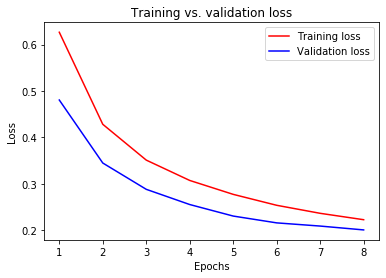

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training vs. validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

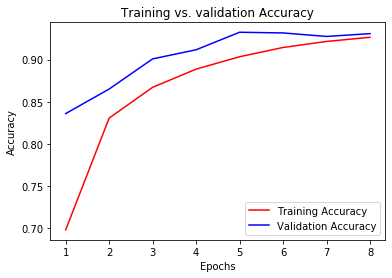

In [61]:
#Plot Accuracy
history_dict = history.history
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training Accuracy') 
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy') 
plt.title('Training vs. validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()

Extract features from Test data to make predictions

In [0]:
indices = []
for i in range(len(X_test)):
  ids, segments = tokenizer.encode(X_test[i],max_len=64)
  indices.append(ids)
indices = np.array(indices)
data_test = [indices, np.zeros_like(indices)]

In [0]:
labels_test = mlb.transform(y_test)

Evaluate the model on test set

In [64]:
model.evaluate(data_test,labels_test)

1000/1000 [==============================] - 2s 2ms/step


[0.23334378230571748, 0.91575]

## **2.5 Make prediction on test data**

In [0]:
y_pred = model.predict(data_test)

Convert probabilities into 1 or 0 based on a threshold. Here, t

In [0]:
y_pred_norm = [[1 if val >= 0.5 else 0 for val in pred]for pred in y_pred]
y_pred_norm = np.array(y_pred_norm)

## **2.6 Evaluate the model based on the matrices used in previous method**

In [0]:
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score, hamming_loss, multilabel_confusion_matrix,jaccard_score, classification_report

In [68]:
y_pred_norm.shape

(1000, 8)

In [69]:
print("Jaccard Similarity : {:.4f}".format(jaccard_score(labels_test, y_pred_norm,average='samples')))
print("Subset Accuracy : {:.4f}".format(accuracy_score(labels_test, y_pred_norm)))
print("Hamming Loss : {:.4f}".format(hamming_loss(labels_test,y_pred_norm)))
print("Precision: {:.4f}".format(precision_score(labels_test, y_pred_norm, average='samples')))
print("Recall   : {:.4f}".format(recall_score(labels_test, y_pred_norm, average='samples')))
print("F1-Score : {:.4f}".format(f1_score(labels_test, y_pred_norm, average='samples')))

Jaccard Similarity : 0.6819
Subset Accuracy : 0.5330
Hamming Loss : 0.0843
Precision: 0.7830
Recall   : 0.7386
F1-Score : 0.7333


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **2.7 BERT classification report**

In [70]:
print(classification_report(labels_test,y_pred_norm))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       176
           1       0.70      0.37      0.49       178
           2       0.80      0.72      0.76       138
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        28
           5       0.89      0.27      0.42        92
           6       0.80      0.75      0.78       383
           7       0.82      0.85      0.83       373

   micro avg       0.80      0.67      0.73      1374
   macro avg       0.60      0.46      0.51      1374
weighted avg       0.78      0.67      0.71      1374
 samples avg       0.78      0.74      0.73      1374



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
